In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DETR not Detectron

## DETR Image

In [ ]:
import torch 
from torch import nn 
from torchvision.models import resnet50 
 
class DETR(nn.Module): 
 
  def __init__(self, num_classes, hidden_dim, nheads, 
               num_encoder_layers, num_decoder_layers): 
    super().__init__() 
    # We take only convolutional layers from ResNet-50 model 
    self.backbone = nn.Sequential(*list(resnet50(pretrained=True).children())[:-2]) 
    self.conv = nn.Conv2d(2048, hidden_dim, 1) 
    self.transformer = nn.Transformer(hidden_dim, nheads, 
    num_encoder_layers, num_decoder_layers) 
    self.linear_class = nn.Linear(hidden_dim, num_classes + 1) 
    self.linear_bbox = nn.Linear(hidden_dim, 4) 
    self.query_pos = nn.Parameter(torch.rand(100, hidden_dim)) 
    self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2)) 
    self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2)) 
 
  def forward(self, inputs): 
    x = self.backbone(inputs) 
    h = self.conv(x) 
    H, W = h.shape[-2:] 
    pos = torch.cat([ 
                    self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1), 
                    self.row_embed[:H].unsqueeze(1).repeat(1, W, 1), 
    ], dim=-1).flatten(0, 1).unsqueeze(1) 
    h = self.transformer(pos + h.flatten(2).permute(2, 0, 1), 
                         self.query_pos.unsqueeze(1)) 
    return self.linear_class(h), self.linear_bbox(h).sigmoid() 

detr = DETR(num_classes=91, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6) 
detr.eval() 
inputs = torch.randn(1, 3, 800, 1200)
logits, bboxes = detr(inputs)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False);

In [ ]:
!pip install git+https://github.com/cocodataset/panopticapi.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-1pohb_25
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-1pohb_25
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8306 sha256=3bedb123f219c2be5dd0371c61c63e000c1960b3fa32b32ba191e2e78860f799
  Stored in directory: /tmp/pip-ephem-wheel-cache-pcpoakw2/wheels/b3/fc/e3/2463e5db55087b06e9c3bb117af1a63a080d1ec4c33291cec9
Successfully built panopticapi


In [ ]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

In [ ]:
# These are the COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
transform

Compose(
    Resize(size=800, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True, num_classes=250)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-panoptic-40021d53.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-panoptic-40021d53.pth


  0%|          | 0.00/237M [00:00<?, ?B/s]

In [ ]:
url = ""http://images.cocodataset.org/val2017/000000281759.jpg""
im = Image.open(requests.get(url, stream=True).raw)

In [ ]:
path = "/content/drive/MyDrive/MP_KSC_000329.jpg"
im = Image.open(path)

In [ ]:
im

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
out = model(img)

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [ ]:
# compute the scores, excluding the "no-object" class (the last one)
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.85

# Plot all the remaining masks
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(out["pred_masks"][keep]):
    ax = axs[i // ncols, i % ncols]
    ax.imshow(mask, cmap="cividis")
    ax.axis('off')
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

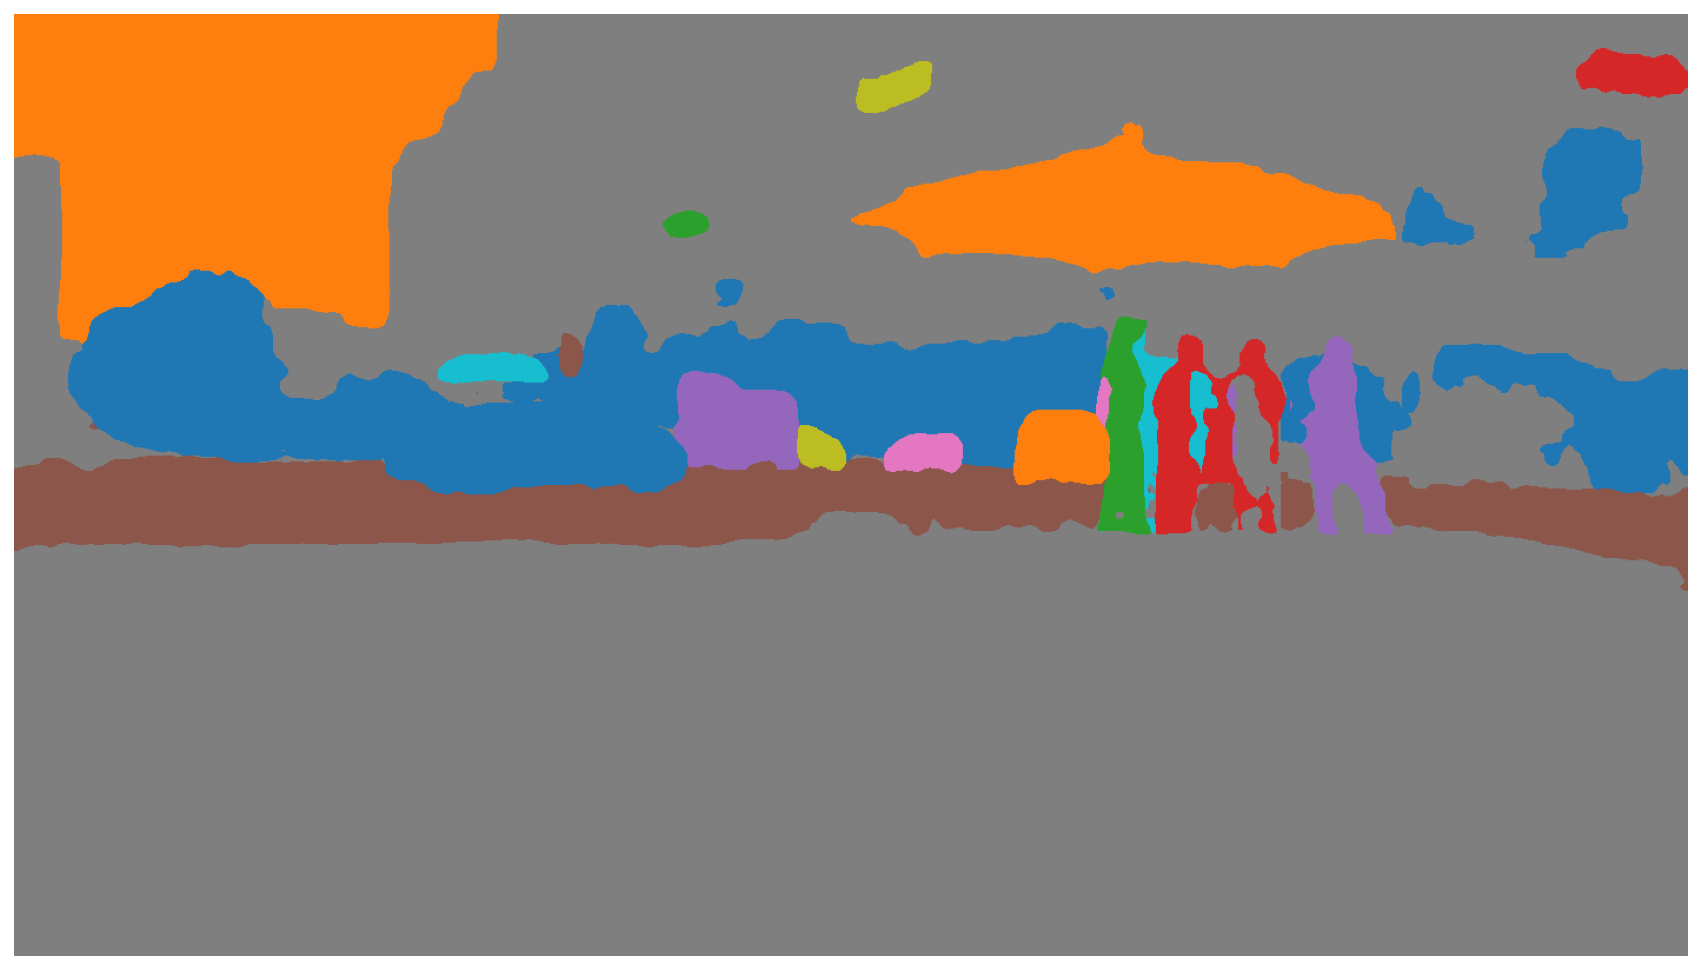

In [ ]:
import itertools
import seaborn as sns
palette = itertools.cycle(sns.color_palette())

# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb2id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show()

In [ ]:
for i in range(panoptic_seg_id.shape[0]):
  for j in range(panoptic_seg_id.shape[1]):
    print(panoptic_seg_id[i][j], end = ' ')
  print("")

In [ ]:
panoptic_seg_id.shape

(800, 1422)

#USING DETECRON2

## old? 

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.12.1+cu113 True


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os,  json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## new?

준비

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 19.5 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=847ccc87b6842810da3543c9b296bdefefa591ecbfd7f97c4081ae31a43f4650
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14634, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [ ]:
from copy import deepcopy
# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

    
    
# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]


# Finally we visualize the prediction
v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
cv2_imshow(v.get_image())

NameError: ignored

## 데이터셋 준비 old




In [ ]:
!unzip -qq "/content/drive/MyDrive/VPS_me/cityscapes-vps-dataset-1.0.zip" -d "/content/data"

In [ ]:
!unzip -qq "/content/data/cityscapes-vps-dataset-1.0/train_gt.zip" -d "/content/data"
!unzip -qq "/content/data/cityscapes-vps-dataset-1.0/val_gt.zip" -d "/content/data"

In [ ]:
from detectron2.data.datasets import cityscapes_panoptic

## 데이터 준비 new

In [ ]:
!unzip -qq "/content/drive/MyDrive/vps/leftImg8bit_trainvaltest.zip" -d "/content/data"

replace /content/data/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/data/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
from glob import glob

file_path = dict()
for d in ["train", "test", "val"]:
  file_path[d] = glob("/content/data/gtFine/" + d + "/*")

In [ ]:
file_path["train"]

In [ ]:
from tqdm import tqdm

json_path = dict()
for d in ["train", "test", "val"]:
  json_list = list()
  for path in tqdm(file_path[d]):
    json_list = json_list + glob(path+"/*.json")
    json_list = sorted(json_list)
  json_path[d] = json_list

100%|██████████| 3/3 [00:00<00:00, 564.86it/s]


In [ ]:
from tqdm import tqdm

img_path = dict()
for d in ["train", "test", "val"]:
  city_path = glob("/content/data/leftImg8bit/" + d + "/*")
  img = list()
  for p in city_path:
    img = img + glob(p+"/*.png")
  img_path[d] = img

In [ ]:
img_path["train"], json_path["train"]

## cityscapes => coco

In [ ]:
!git clone https://github.com/TillBeemelmanns/cityscapes-to-coco-conversion

Cloning into 'cityscapes-to-coco-conversion'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 28 (delta 5), reused 23 (delta 4), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [ ]:
!unzip -qq "/content/drive/MyDrive/gtFine_trainvaltest.zip" -d "/content/data"
!unzip -qq "/content/drive/MyDrive/vps/leftImg8bit_trainvaltest.zip" -d "/content/data"

replace /content/data/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
%cd /content/cityscapes-to-coco-conversion
!pip install -r requirements.txt 

In [ ]:
%cd /content/cityscapes-to-coco-conversion
!python main.py --dataset cityscapes --datadir data/cityscapes --outdir data/cityscapes/annotations

In [ ]:
from detectron2.structures import BoxMode

img_dir = "/content/drive/MyDrive/PanopticSegmentation/CityScapes"

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json") # 영역이 저장되어 있는 json file
    with open(json_file) as f:
        imgs_anns = json.load(f) # image 어노테이션 
    # train image의 모든 어노테이션이 들어가 있음

    dataset_dicts = [] #딕셔너리 형태로 저장하기 위한 
    for idx, v in enumerate(imgs_anns.values()): 
        record = {} # 어노테이션 결과물
        
        filename = os.path.join(img_dir, v["filename"]) # 파일 이름 저장 
        height, width = cv2.imread(filename).shape[:2] # 사진 크기
        
        record["file_name"] = filename # 딕셔너리로 저장
        record["image_id"] = idx # 그냥 인덱스
        record["height"] = height # height
        record["width"] = width # width
      
        annos = v["regions"] # 어노테이션된게 regions에 있음
        objs = []
        for _, anno in annos.items(): # json에서 하나씩 가져오기 위한
            assert not anno["region_attributes"] 
            # 세그멘테이션
            anno = anno["shape_attributes"] #어노테이션 결과값
            px = anno["all_points_x"] # point x
            py = anno["all_points_y"] # point y
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)] # 폴리곤 값 가져오기
            poly = [p for x in poly for p in x] # 

            obj = { # object 가져오기
                # 바운딩 박스
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0, # 풍선 하나밖에 없기 때문에 category_id 는 하나
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
        
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

In [ ]:
dataset_dicts = [] #딕셔너리 형태로 저장하기 위한 
img_dir = "/content/drive/MyDrive/PanopticSegmentation/CityScapes"

# imgs_anns.keys() : images, categories, annotations
# images : [{'id': 0, 'width': 2048, 'height': 1024, 'file_name': 'leftImg8bit/train/krefeld/krefeld_000000_003096_leftImg8bit.png', 'seg_file_name': 'krefeld_000000_003096_gtFine_instanceIds.png'},...]
# categories : [{'id': 1, 'name': 'rider'}, ...]
# annotations : [{'id': 0, 'image_id': 0,  'segmentation': [[363, ...]], 'category_id': 1,  'iscrowd': 0,  'area': 17505,  'bbox': [283, 300, 155, 276]}

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "instancesonly_filtered_gtFine_train.json") # 영역이 저장되어 있는 json file
    with open(json_file) as f:
        imgs_anns = json.load(f) # image 어노테이션 
    # train image의 모든 어노테이션이 들어가 있음

    dataset_dicts = list() #딕셔너리 형태로 저장하기 위한 
    for v in imgs_anns["images"]: 
        record = dict()
        record["file_name"] = v["file_name"]
        record["image_id"] = v["id"]
        record["height"] = v["height"]
        record["width"] = v["width"]

        

    for idx, v in enumerate(imgs_anns[]): 
        record = {} # 어노테이션 결과물
        
      
        annos = v["regions"] # 어노테이션된게 regions에 있음
        objs = []
        for _, anno in annos.items(): # json에서 하나씩 가져오기 위한
            assert not anno["region_attributes"] 
            # 세그멘테이션
            anno = anno["shape_attributes"] #어노테이션 결과값
            px = anno["all_points_x"] # point x
            py = anno["all_points_y"] # point y
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)] # 폴리곤 값 가져오기
            poly = [p for x in poly for p in x] # 

            obj = { # object 가져오기
                # 바운딩 박스
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0, # 풍선 하나밖에 없기 때문에 category_id 는 하나
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
        
    return dataset_dicts


In [ ]:
from detectron2.data import MetadataCatalog, DatasetCatalog

DatasetCatalog.register("cityscapes_train", imgs_anns)
MetadataCatalog.get("balloon_train").set(thing_classes=["balloon"])

NameError: ignored

In [ ]:
from detectron2.data import MetadataCatalog, DatasetCatalog

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

In [ ]:
!unzip -qq "/content/drive/MyDrive/PanopticSegmentation/COCO/panoptic_annotations_trainval2017.zip" -d "/content/sample_data"

In [ ]:
!pip install git+https://github.com/cocodataset/panopticapi.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-5sdalkx7
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-5sdalkx7
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8306 sha256=a8c5e9e73b9d87c08e83ec7e0c3d8ce6ddbc39d0d6f2877144b187e451d88d52
  Stored in directory: /tmp/pip-ephem-wheel-cache-xm6i4397/wheels/b3/fc/e3/2463e5db55087b06e9c3bb117af1a63a080d1ec4c33291cec9
Successfully built panopticapi


## 셀프로 만들어보기

* {
"images": [image], "annotations": [annotation], categories : [categories]
}

* image{
"id": int, "width": int, "height": int, "file_name": str, "seg_file_name": str
}

* annotation{
"image_id": int, "file_name": str, "segments_info": [segment_info],
}

* segment_info{
"id": int, "category_id": int, "area": int, "bbox": [x,y,width,height], "iscrowd": 0 or 1,
}

* categories[{
"id": int, "name": str, "supercategory": str, "isthing": 0 or 1, "color": [R,G,B],
}]


*   imgs_anns.keys() : images, categories, annotations
*images : [{'id': 0, 'width': 2048, 'height': 1024, 'file_name': 'leftImg8bit/train/krefeld/krefeld_000000_003096_leftImg8bit.png', 'seg_file_name': 'krefeld_000000_003096_gtFine_instanceIds.png'},...]
*categories : [{'id': 1, 'name': 'rider'}, ...]
*annotations : [{'id': 0, 'image_id': 0,  'segmentation': [[363, ...]], 'category_id': 1,  'iscrowd': 0,  'area': 17505,  'bbox': [283, 300, 155, 276]}


detectron import

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 31.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=96d66b86759a02478aa78667203244cd6bc6e256b986848e9ed88d07ff15f0cb
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14634, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


file unzip

In [ ]:
!unzip -qq "/content/drive/MyDrive/gtFine_trainvaltest.zip" -d "/content/data"
!unzip -qq "/content/drive/MyDrive/vps/leftImg8bit_trainvaltest.zip" -d "/content/data"

replace /content/data/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


fila path 가져옴

In [ ]:
from glob import glob
from tqdm import tqdm
import os

def gain_path(path):
  """
  path : 전체 directory path
  """
  
  city = dict()
  for d in ["train", "test", "val"]:
    city[d] = os.listdir(path + "/gtFine/" + d) # 각 데이터셋별로 city 가져옴
    
  json_path = dict()
  seg_path = dict()
  img_path = dict()
    
  for d in ["train", "test", "val"]:
    json_list = list()
    seg_list = list()
    img_list = list()
    for c in city[d]:
      json_list = json_list + glob(os.path.join(path,"gtFine", d, c, "*.json"))
      seg_list = seg_list + glob(os.path.join(path,"gtFine", d, c, "*gtFine_color.png"))
      img_list = img_list + glob(os.path.join(path,"leftImg8bit", d, c, "*.png"))
    json_path[d] = sorted(json_list)
    seg_path[d] = sorted(seg_list)
    img_path[d] = sorted(img_list)
  
  return img_path, json_path, seg_path

path = "/content/data"
img_path, json_path, seg_path = gain_path(path)

In [ ]:
len(json_path["train"]), len(img_path["train"]), len(seg_path["train"])

(2975, 2975, 2975)

### maybe?

cityscapes annotation to coco annotation

In [ ]:
img_path["train"][0], seg_path["train"][0], json_path["train"][0]

('/content/data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png',
 '/content/data/gtFine/train/aachen/aachen_000000_000019_gtFine_color.png',
 '/content/data/gtFine/train/aachen/aachen_000000_000019_gtFine_polygons.json')

category dict

In [ ]:
from collections import namedtuple

def get_categories():
  Label = namedtuple( 'Label' , [

      'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                      # We use them to uniquely name a class

      'id'          , # An integer ID that is associated with this label.
                      # The IDs are used to represent the label in ground truth images
                      # An ID of -1 means that this label does not have an ID and thus
                      # is ignored when creating ground truth images (e.g. license plate).
                      # Do not modify these IDs, since exactly these IDs are expected by the
                      # evaluation server.

      'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                      # ground truth images with train IDs, using the tools provided in the
                      # 'preparation' folder. However, make sure to validate or submit results
                      # to our evaluation server using the regular IDs above!
                      # For trainIds, multiple labels might have the same ID. Then, these labels
                      # are mapped to the same class in the ground truth images. For the inverse
                      # mapping, we use the label that is defined first in the list below.
                      # For example, mapping all void-type classes to the same ID in training,
                      # might make sense for some approaches.
                      # Max value is 255!

      'category'    , # The name of the category that this label belongs to

      'categoryId'  , # The ID of this category. Used to create ground truth images
                      # on category level.

      'hasInstances', # Whether this label distinguishes between single instances or not

      'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                      # during evaluations or not

      'color'       , # The color of this label
      ] )


  labels = [
      #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
      Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
      Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
      Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
      Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
      Label(  'static'               ,  4 ,      255 , 'void'            , 0       , True        , True         , (  0,  0,  0) ),
      Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , True        , True         , (111, 74,  0) ),
      Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , True        , True         , ( 81,  0, 81) ),
      Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , True         , False        , (128, 64,128) ),
      Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , True         , False        , (244, 35,232) ),
      Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , True         , True         , (250,170,160) ),
      Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , True         , True         , (230,150,140) ),
      Label(  'building'             , 11 ,        2 , 'construction'    , 2       , True         , False        , ( 70, 70, 70) ),
      Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , True         , False        , (102,102,156) ),
      Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , True         , False        , (190,153,153) ),
      Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , True         , True         , (180,165,180) ),
      Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , True         , True         , (150,100,100) ),
      Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , True         , True         , (150,120, 90) ),
      Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , True         , False        , (153,153,153) ),
      Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , True         , True         , (153,153,153) ),
      Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , True         , False        , (250,170, 30) ),
      Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , True         , False        , (220,220,  0) ),
      Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , True         , False        , (107,142, 35) ),
      Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , True         , False        , (152,251,152) ),
      Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , True         , False        , ( 70,130,180) ),
      Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
      Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
      Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
      Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
      Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
      Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
      Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
      Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
      Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
      Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
      Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
  ]

  categories = list()
  for label in labels:
    cat = dict()
    cat["id"] = label.id
    cat["name"] = label.name
    cat["supercategory"] = label.category
    cat["color"] = label.color
    if label.name in ["person", "rider", "car", "truck", "bus", "train", "motorcycle", "bicycle"]:
      cat["isthing"] = 1
    else:
      cat["isthing"] = 0
    categories.append(cat)
  
  return categories

image, segment_info, annotation

In [ ]:
import numpy as np

def seg_info(polygon):
  """
  polygon : segment의 polygon 
  """
  x = list()
  y = list()

  for xy in polygon:
    x.append(xy[0])
    y.append(xy[1])

  area = int(0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1))))
  bbox = [np.min(x), np.min(y), np.max(x)-np.min(x), np.max(y)-np.min(y)] 
  return area, bbox

In [ ]:
import json
import numpy

def cityscapes2coco(img_path, json_path, seg_path):
  """
  img_path : 
  json_path :
  seg_path :
  """
  image = list()
  annotation = list()
  categories = get_categories()
  for i, json_file in enumerate(json_path):
    with open(json_file) as f:
      imgs_anns = json.load(f) # image 어노테이션 
    
    img = dict()
    img["id"] = i
    img["width"] = imgs_anns["imgHeight"]
    img["height"] = imgs_anns["imgWidth"]
    img["file_name"] = img_path[i]
    image.append(img)

    segment = list()
    seg_id = 0
    for j, obj in enumerate(imgs_anns["objects"]):
      seg = dict()
      seg["id"] = seg_id + j
      if "group" in obj["label"]:
        seg["iscrowd"] = 1
        obj["label"] = obj["label"].replace("group","")
      else:
        seg["iscrowd"] = 0

      for id in categories:
        if id["name"] == obj["label"]:
          seg["category_id"] = id["id"]
      
      seg["area"], seg["bbox"] = seg_info(obj["polygon"])

      segment.append(seg)

      anno = dict()
      anno["image_id"] = i
      anno["file_name"] = seg_path[i].split('/')[-1]# 이거 세그먼트된 이미지 파일 경로를 넘기는 건가?
      anno["segment_info"] = segment
      annotation.append(anno)


  return image, annotation, categories

In [ ]:
def get_cityscapes_dicts(directory):

  image, anno, category = cityscapes2coco(img_path[directory], json_path[directory], seg_path[directory])

  c_dict = dict()
  c_dict["images"] = image
  c_dict["annotations"] = anno
  c_dict["categories"] = category

  return c_dict

In [ ]:
city_dict = get_cityscapes_dicts("train")

In [ ]:
cat = get_categories()

In [ ]:
a = list()
for col in cat:
  a.append(col["name"])

In [ ]:
from detectron2.data import MetadataCatalog, DatasetCatalog

for d in ["train", "val"]:
    DatasetCatalog.register("cityscapes_" + d, lambda d=d: get_cityscapes_dicts(d))
    MetadataCatalog.get("cityscapes_" + d).set(thing_classes=a)
balloon_metadata = MetadataCatalog.get("cityscapes_train")

### detectron 형식으로 맞춰주기

In [ ]:
!git clone https://github.com/mcordts/cityscapesScripts.git

Cloning into 'cityscapesScripts'...
remote: Enumerating objects: 630, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 630 (delta 172), reused 153 (delta 150), pack-reused 427
Receiving objects: 100% (630/630), 792.25 KiB | 3.31 MiB/s, done.
Resolving deltas: 100% (358/358), done.


In [ ]:
!pip install git+https://github.com/cocodataset/panopticapi.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-toi084ir
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-toi084ir
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8306 sha256=d18237abf9070e7c7f54ae82bc1ead7e38275b2c0223833c96c4d2cc53bcd564
  Stored in directory: /tmp/pip-ephem-wheel-cache-pqppkwgr/wheels/b3/fc/e3/2463e5db55087b06e9c3bb117af1a63a080d1ec4c33291cec9
Successfully built panopticapi


In [ ]:
import json, os
# len(json_path["train"]), len(img_path["train"]), len(seg_path["train"])
#     img = dict()
#     img["id"] = i
#     img["width"] = imgs_anns["imgHeight"]
#     img["height"] = imgs_anns["imgWidth"]
#     img["file_name"] = img_path[i]
#     image.append(img)

def get_dic_cityscapes(dir):
  img = img_path[dir]
  seg = seg_path[dir]
  json = json_path[dir]
  category = get_categories()

  annotation = list()
  # json file이 한 이미지마타 하나씩 있어서 하나씩 다 만들어줘야함
  for i, json_file in enumerate(json):
    with open(json_file) as f:
      imgs_anns = json.load(f) # image 어노테이션 :
    
    result = dict()
    result["file_name"] = img[i]
    result["width"] = imgs_anns["imagWidth"]
    result["height"] = imgs_anns["imgHeight"]
    result["image_idc"] = img[i].split('/')[-1] # filename.png

    seg_info = list()

    result["pan_seg_file_name"]
    result["segments_info"]
    
    


## 학습

내장함수를 이용하여 cityscapes 데이터 생성

In [ ]:
!python /content/cityscapesScripts/cityscapesscripts/preparation/createPanopticImgs.py \
--dataset-folder "/content/cityscapes/gtFine"

Converting 500 annotation files for val set.
Json file with the annotations in panoptic format will be saved in /content/cityscapes/gtFine/cityscapes_panoptic_val.json
Corresponding segmentations in .png format will be saved in /content/cityscapes/gtFine/cityscapes_panoptic_val
Progress: 1.60 % ^C


In [ ]:
!python /content/cityscapesScripts/cityscapesscripts/preparation/createTrainIdLabelImgs.py

Processing 5000 annotation files
Progress: 100.0 % 

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

In [ ]:
# 전이학습을 위한 모델 불러오기
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.DATASETS.TRAIN = ("cityscapes_fine_panoptic_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml") # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

In [ ]:
trainer.train()

## 몰?루

[폴더 구조]
cityscapes
>- annotations
>>- panoptic_train2017.json
 - panoptic_val2017.json
>-train2017
>>- img.png
>-val2017
>>- img.png

In [ ]:
!unzip -qq "/content/drive/MyDrive/gtFine_trainvaltest.zip" -d "/content/cityscapes"
!unzip -qq "/content/drive/MyDrive/vps/leftImg8bit_trainvaltest.zip" -d "/content/cityscapes"

In [ ]:
!pip install git+https://github.com/mcordts/cityscapesScripts.git
!git clone https://github.com/mcordts/cityscapesScripts

In [ ]:
!pip install git+https://github.com/cocodataset/panopticapi.git
!git clone https://github.com/cocodataset/panopticapi.git

바꿔줘야 하는 것
/content/panopticapi/cityscapes_gt_converter/cityscapes_panoptic_converter.py

 train <-> val
- original_format_folder = '/content/cityscapes/gtFine/val'
-out_folder = '/content/coco/val2017'
-out_file = '/content/coco/panoptic_val2017.json'
-이외 int형식은 싹다 int() 붙여주기

In [ ]:
!python /content/panopticapi/cityscapes_gt_converter/cityscapes_panoptic_converter.py

In [94]:
%cd /content/panopticapi
!python /content/panopticapi/converters/panoptic2semantic_segmentation.py \
  --input_json_file /content/drive/MyDrive/PanopticSegmentation/DETR/coco_panoptic/annotations/panoptic_val2017.json \
  --output_json_file /content/drive/MyDrive/PanopticSegmentation/DETR/coco/annotations/instance_val2017.json

/content/panopticapi
EXTRACTING FROM...
COCO panoptic format:
	Segmentation folder: /content/drive/MyDrive/PanopticSegmentation/DETR/coco_panoptic/annotations/panoptic_val2017
	JSON file: /content/drive/MyDrive/PanopticSegmentation/DETR/coco_panoptic/annotations/panoptic_val2017.json
SEMANTIC SEGMENTATION
in COCO detection format:
	JSON file: /content/drive/MyDrive/PanopticSegmentation/DETR/coco/annotations/instance_val2017.json


Number of cores: 2, images per core: 250
Core: 1, 0 from 250 images processed
Core: 0, 0 from 250 images processed
Caught exception in worker thread:
Caught exception in worker thread:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/content/panopticapi/converters/panoptic2semantic_segmentation.py", line 52, in extract_semantic_single_core
    Image.open(os.path.join(segmentations_folder, annotation['file_name'])),
  File "/usr/local/lib/python3.8/dist-packages/PIL/Image.py", line 2843, in open
    fp = builtins.open(filename, "r

원본 이미지 옮기기


cityscapes_panoptic_converter.py
```
#!/usr/bin/env python
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import os, sys
import json
import glob
import numpy as np
import PIL.Image as Image
from tqdm import tqdm

from panopticapi.utils import IdGenerator, save_json

try:
    # set up path for cityscapes scripts
    # sys.path.append('./cityscapesScripts/')
    from cityscapesscripts.helpers.labels import labels, id2label
except Exception:
    raise Exception("Please load Cityscapes scripts from https://github.com/mcordts/cityscapesScripts")

original_format_folder = '/content/cityscapes/gtFine/val'
original_image_folder = "/content/cityscapes/leftImg8bit/val"
# folder to store panoptic PNGs
out_folder = '/content/coco_panoptic/panoptic_val2017'
out_img_folder = '/content/coco/val2017'
# json with segmentations information
out_file = '/content/coco/annotations/cityscapes_panoptic_val.json'

def panoptic_converter(original_format_folder, out_folder, out_file):

    if not os.path.isdir(out_folder):
        print("Creating folder {} for panoptic segmentation PNGs".format(out_folder))
        os.mkdir(out_folder)

    categories = []
    for idx, el in enumerate(labels):
        if el.ignoreInEval:
            continue
        categories.append({'id': el.id,
                           'name': el.name,
                           'color': el.color,
                           'supercategory': el.category,
                           'isthing': 1 if el.hasInstances else 0})

    categories_dict = {cat['id']: cat for cat in categories}

    file_list = sorted(glob.glob(os.path.join(original_format_folder, '*/*_gtFine_instanceIds.png')))

    images = []
    annotations = []
    for working_idx, f in enumerate(file_list):
        if working_idx % 10 == 0:
            print(working_idx, len(file_list))

        original_format = np.array(Image.open(f))

        file_name = f.split('/')[-1]
        image_id = file_name.rsplit('_', 2)[0]
        image_filename= '{}.png'.format(image_id)
        # image entry, id for image is its filename without extension
        images.append({"id": image_id,
                       "width": original_format.shape[1],
                       "height": original_format.shape[0],
                       "file_name": image_filename})

        pan_format = np.zeros((original_format.shape[0], original_format.shape[1], 3), dtype=np.uint8)
        id_generator = IdGenerator(categories_dict)

        idx = 0
        l = np.unique(original_format)
        segm_info = []
        for el in l:
            if el < 1000:
                semantic_id = el
                is_crowd = 1
            else:
                semantic_id = el // 1000
                is_crowd = 0
            if semantic_id not in categories_dict:
                continue
            if categories_dict[semantic_id]['isthing'] == 0:
                is_crowd = 0
            mask = original_format == el
            segment_id, color = id_generator.get_id_and_color(semantic_id)
            pan_format[mask] = color

            area = np.sum(mask) # segment area computation

            # bbox computation for a segment
            hor = np.sum(mask, axis=0)
            hor_idx = np.nonzero(hor)[0]
            x = hor_idx[0]
            width = hor_idx[-1] - x + 1
            vert = np.sum(mask, axis=1)
            vert_idx = np.nonzero(vert)[0]
            y = vert_idx[0]
            height = vert_idx[-1] - y + 1
            bbox = [int(x), int(y), int(width), int(height)]

            segm_info.append({"id": int(segment_id),
                              "category_id": int(semantic_id),
                              "area": float(area),
                              "bbox": bbox,
                              "iscrowd": int(is_crowd)})

        annotations.append({'image_id': image_id,
                            'file_name': image_filename,
                            "segments_info": segm_info})

        Image.fromarray(pan_format).save(os.path.join(out_folder, image_filename))

    d = {'images': images,
         'annotations': annotations,
         'categories': categories,
        }

    save_json(d, out_file)
    
    image_list = sorted(glob.glob(os.path.join(original_image_folder, '*/*_leftImg8bit.png')))

    for f in tqdm(image_list):
        file_name = '_'.join(f.split('/')[-1].split('_')[:3])+'.png'
        image_filename= '{}.png'.format(file_name)

        img = Image.open(os.path.join(f))
        img.save(os.path.join(out_img_folder, image_filename))


if __name__ == "__main__":
    panoptic_converter(original_format_folder, out_folder, out_file)
```



In [ ]:
!git clone https://github.com/facebookresearch/detr.git

Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 12.87 MiB | 17.21 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [ ]:
%cd /content/detr
!python -m torch.distributed.launch --nproc_per_node=1 --use_env main.py --coco_path /content/drive/MyDrive/PanopticSegmentation/DETR/coco  --coco_panoptic_path /content/drive/MyDrive/PanopticSegmentation/DETR/coco_panoptic --dataset_file coco_panoptic --output_dir /content/result

In [ ]:
import glob ,os
original_image_folder = "/content/cityscapes/leftImg8bit/val"

image_list = sorted(glob.glob(os.path.join(original_image_folder, '*/*_leftImg8bit.png')))

In [ ]:
for f in image_list:
    file_name = '_'.join(f.split('/')[-1].split('_')[:3])+'.png'
    image_filename= '{}.png'.format(file_name)

frankfurt_000000_000294.png


In [ ]:
f = "/content/cityscapes/gtFine/val/munster/munster_000000_000019_gtFine_instanceIds.png"
# /content/cityscapes/gtFine/val/munster/munster_000000_000019_gtFine_polygons.json

In [ ]:
f.replace("instanceIds.png", "polygons.json")

'/content/cityscapes/gtFine/val/munster/munster_000000_000019_gtFine_polygons.json'

In [ ]:
json_file = "/content/cityscapes/gtFine/val/munster/munster_000000_000019_gtFine_polygons.json"

with open(json_file) as j:
  imgs_anns = json.load(j) # image 어노테이션 


In [ ]:
imgs_anns.keys()

dict_keys(['imgHeight', 'imgWidth', 'objects'])

In [ ]:
!unzip -qq "/content/drive/MyDrive/PanopticSegmentation/COCO/panoptic_annotations_trainval2017.zip" -d "/content/data"
!unzip -qq "/content/drive/MyDrive/PanopticSegmentation/COCO/train2017.zip" -d "/content/data"

In [ ]:
!unzip -qq "/content/data/annotations/panoptic_train2017.zip" -d "/content/data"

# cityscapes 포기 coco로 가자

## unzip

In [97]:
!unzip -qq "/content/drive/MyDrive/PanopticSegmentation/COCO/panoptic_annotations_trainval2017.zip" -d "/content/data/coco_panoptic"

In [98]:
!unzip -qq "/content/data/coco_panoptic/annotations/panoptic_train2017.zip" -d "/content/data/coco_panoptic"

In [99]:
!unzip -qq "/content/data/coco_panoptic/annotations/panoptic_val2017.zip" -d "/content/data/coco_panoptic"

In [100]:
!unzip -qq "/content/drive/MyDrive/PanopticSegmentation/COCO/train2017.zip" -d "/content/data/coco"
!unzip -qq "/content/drive/MyDrive/PanopticSegmentation/COCO/val2017.zip" -d "/content/data/coco"

## detr

In [95]:
!git clone https://github.com/facebookresearch/detr.git

Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 12.87 MiB | 37.67 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [96]:
%cd /content/detr
!python -m torch.distributed.launch --nproc_per_node=8 --use_env main.py --coco_path /content/data/coco --coco_panoptic_path /content/data/coco_panoptic --dataset_file coco_panoptic --output_dir /content/drive/MyDrive/DETR_되냐

/content/detr
/usr/local/lib/python3.8/dist-packages/torch/distributed/launch.py:180: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
| distributed init (rank 0): env://
Traceback (most recent call last):
  File "main.py", line 248, in <module>
    main(args)
  File "main.py", line 106, in main
    utils.init_distributed_mode(args)
  File "/content/detr/util/misc.py", line 428, in init_distributed_mode
    torch.distributed.barrier()
  File "/usr/local/lib/python3.8/dist-packages/torch/distributed/distributed_c10d.py", line 3145, in barrier
    work = default_pg.barrier(opts=opts)
KeyboardInterrupt
Traceback (most recent call last):
  File "/